In [ ]:
import gym
import torch
import gym_nav
import numpy as np

import sys
sys.path.append('../')
from evaluation import *
from model_evaluation import *
from trajectories import *
%run ../evaluation 

from tqdm import tqdm
import itertools

In [ ]:
def split_by_rew(targets_to_split, rews):
    '''
    Used to find when in an explore task the goal was reached based on
    when reward was earned. 

    For example, 
    res = evalu(...)
    ep_pos = split_by_ep(res['data']['pos'], res['rewards'])
    '''
    split_idxs = np.where(np.vstack(rews == 1))[0] + 1
    
    # if nothing to split
    if len(split_idxs) == 0:
        return [targets_to_split]

    split_targets = []
    for i in range(len(split_idxs)):
        if i == 0:
            done_targets = targets_to_split[:split_idxs[i]]
        else:
            done_targets = targets_to_split[split_idxs[i-1]:split_idxs[i]]
        split_targets.append(done_targets)
        
    if split_idxs[-1] != len(rews):
        split_targets.append(targets_to_split[split_idxs[-1]:])
        
    return split_targets


def compute_search_efficiency(pos, covered_distance=10):
    '''
    Compute search efficiency based on how many spots agent managed to get close to
    
    covered_distance: how close the agent had to get to a point to count as covered
        this should probably related to speed agent moves and goal size?
    '''
    
    test_points = np.stack(np.meshgrid(np.linspace(0, 300, 301), np.linspace(0, 300, 301))).reshape(2, -1).T
    unique_pos = np.unique(pos, axis=0)
    
    dists = []
    for p in unique_pos:
        dists.append(np.sqrt(np.sum((test_points - p) ** 2, axis=1)))
    min_dists = np.vstack(dists).min(axis=0)
    
    color_points = np.full(test_points.shape, False)
    color_points[min_dists < 10] = True
    color_points = color_points.all(axis=1).reshape(301, 301) #this can be plt.imshow'd to see what counts as visited
    num_covered_points = color_points.sum()
    
    total_points = 301*301
    cover_efficiency = num_covered_points / total_points / pos.shape[0]
    
    return cover_efficiency
    
    
def compute_eps_search_efficiency(all_pos, all_rew, ret_trials=False):
    '''
    Compute the mean and std search efficiency of an agent across multiple episodes
    Note we are assuming that all_pos and all_rew are already split by episode which
        they should be coming from an evaluate() call
        
    ret_trials: return individual values rather than mean and std, for example for boxplots    
    
    Ex. 
    res = evaluate(model, obs_rms, env_kwargs=env_kwargs, num_episodes=5, data_callback=nav_data_callback)
    compute_eps_search_efficiency(res['data']['pos'], res['rewards']
    '''
    
    explore_efficiencies = []

    for ep in range(len(all_rew)):
        rew = all_rew[ep]
        pos = all_pos[ep]

        split_pos = split_by_rew(pos, rew)
        split_rew = split_by_rew(rew, rew)

        for p in split_pos:
            explore_efficiencies.append(compute_search_efficiency(p))
            
    mean_eff = np.mean(explore_efficiencies)
    std_eff = np.std(explore_efficiencies)
    
    if ret_trials:
        return explore_efficiencies
    else:
        return mean_eff, std_eff
    
    
def test_search_efficiency(model, obs_rms, test_set=2, env_kwargs={}, ret_res=False,
                          manual_starts=None):
    '''
    Test an agent's exploring efficiency given fixed starting points
    
    env_kwargs: extra arguments to give
    manual_starts: option to pass [reset_points, reset_angles] to use manually
    '''
    if test_set == 0:
        reset_points = [np.array([150., 150.])]
        reset_angles = [np.pi/2]
    
    elif test_set == 1:
        reset_points = [np.array([150., 150.]),
                        np.array([10., 290.])]
        reset_angles = [np.pi/2,
                        0.]
    
    elif test_set == 2:
        reset_points = [np.array([150., 150.]),
                        np.array([10., 290.]),
                        np.array([290., 290.]),
                        np.array([290., 10.]),
                        np.array([10., 10.])]
        reset_angles = [np.pi/2,
                        0.,
                        -np.pi/2,
                        np.pi/2,
                        0.]
        
    if manual_starts is not None:
        reset_points = manual_starts[0]
        reset_angles = manual_starts[1]
        
    effs = []
    trajs = []
    ress = []
    for point, angle in zip(reset_points, reset_angles):
        kw = {'goal_size': 1e-8, 'fixed_reset': [point, angle],
          'max_steps': 500}
        for k in env_kwargs:
            kw[k] = env_kwargs[k]
            
        res = evaluate(model, obs_rms, env_kwargs=kw,
                       env_name='ExploreNav-v0', num_episodes=1, 
                       data_callback=nav_data_callback)
        eff, _ = compute_eps_search_efficiency(res['data']['pos'], res['rewards'])
        effs.append(eff)
        trajs.append((res['data']['pos'][0], res['data']['angle'][0]))
        ress.append(res)
        
    if ret_res:
        return effs, trajs, ress
    return effs, trajs

    


    
    

In [35]:


obs_sets = [2, 3, 4, 5]
network_sizes = [64, 128, 256]

obs = 3
hidden = 64
trial = 0

exp_name = f'explorenav_pos/expl_goalpos_obs{obs}hidden{hidden}'
save_file = exp_name + f'_t{trial}.pt'
model, obs_rms = torch.load(f'../saved_models/{save_file}')

env_kwargs = {'rew_structure': 'explorepunish1_explorebonus',
              'sub_goal_reward': 0.04, 'bonus_multiplier': 5,
              'explore_punish_arg': 5, 'obs_set': obs}

res = evaluate(model, obs_rms, env_name='ExploreNav-v0', env_kwargs=env_kwargs,
               num_episodes=5, capture_video=False, data_callback=explore_data_callback)


(Figure(nrows=1, ncols=1, refwidth=2.5),
 SubplotGrid(nrows=1, ncols=1, length=1))

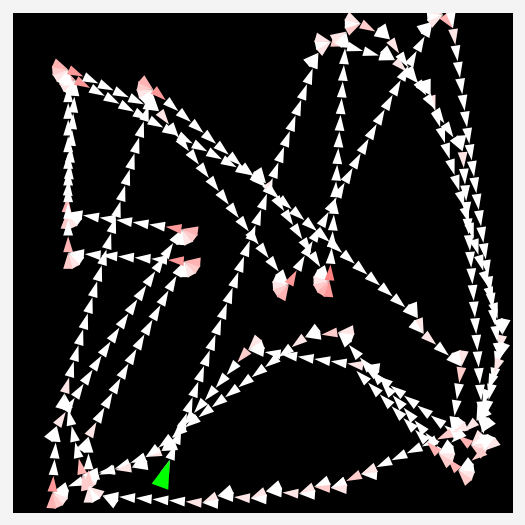

In [52]:
ep = 1
rew = res['rewards'][ep]
hanging_steps = (rew == -0.04).sum()
explore_steps = ((rew > 0.16) & (rew <= 0.2)).sum()
goal_steps = (rew > 0.2).sum()

pos = res['data']['pos'][ep]
angle = res['data']['angle'][ep]

draw_trajectory(pos, angle)

In [53]:
res['data']

0

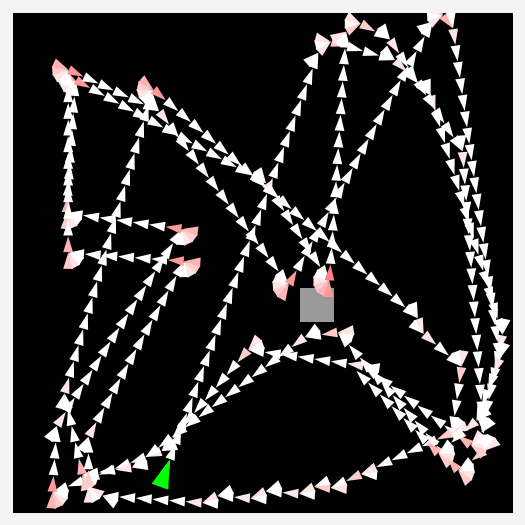

In [51]:
fig, ax = pplt.subplots()

ep = 1

draw_box(res['data']['goal'][ep][0], ax=ax)
p = res['data']['pos'][ep]
a = res['data']['angle'][ep]
draw_trajectory(p, a, ax=ax)

ax.format(xlim=[0, 300], ylim=[0, 300])

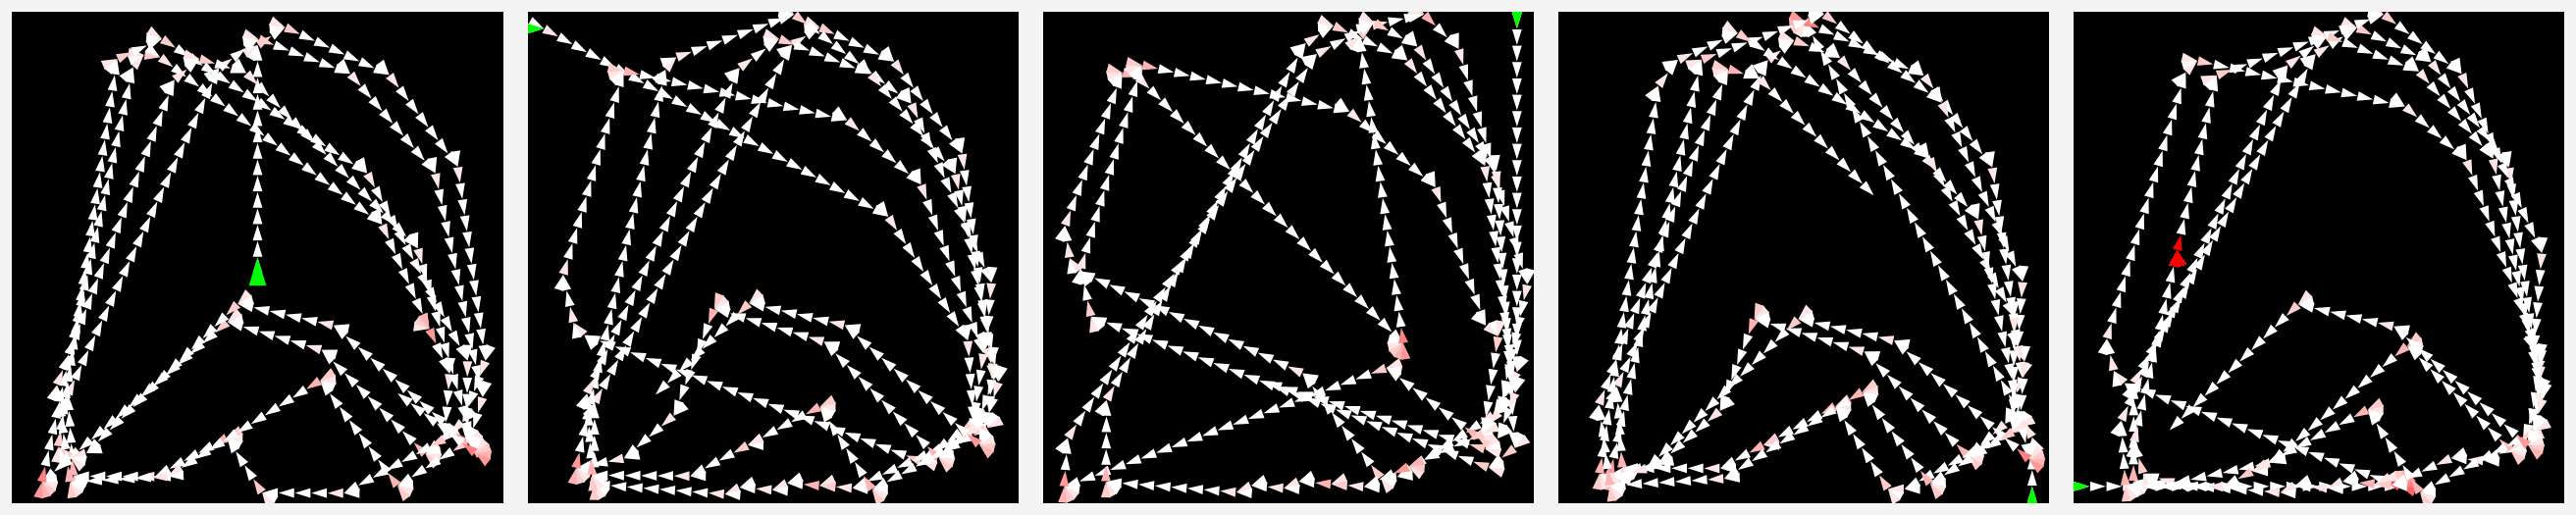

In [50]:
effs, trajs = test_search_efficiency(model, obs_rms, env_kwargs=env_kwargs)

fig, ax = pplt.subplots(ncols=5)

for i in range(5):
    draw_trajectory(trajs[i][0], trajs[i][1], ax=ax[i])

In [56]:
reset_points

[array([127.48644128,  81.35515921]),
 array([94.36895311, 31.61538036]),
 array([165.04052157, 161.79566278])]

In [57]:
reset_angles

[array([-1.00197121]), array([1.2206895]), array([-2.65376796])]

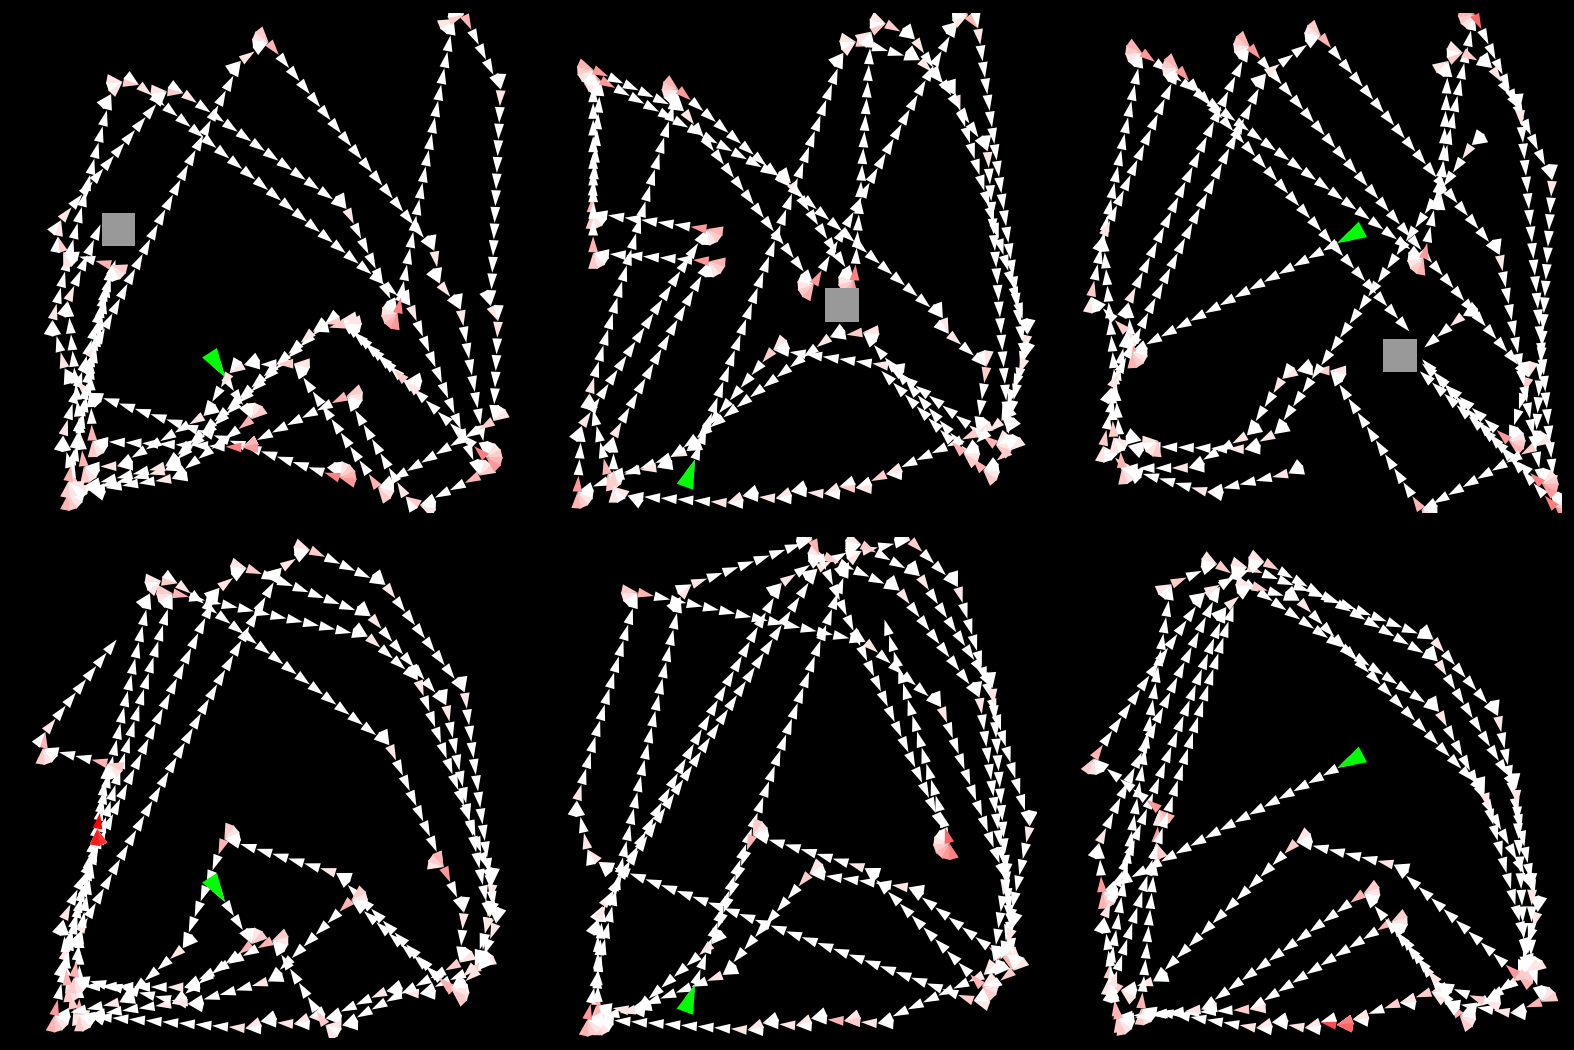

In [128]:
reset_points = []
reset_angles = []
for ep in range(3):
    p = res['data']['pos'][ep][0]
    a = res['data']['angle'][ep][0][0]
    
    reset_points.append(p)
    reset_angles.append(a)
    
    
effs, trajs, res2 = test_search_efficiency(model, obs_rms, env_kwargs=env_kwargs,
                                    manual_starts=[reset_points, reset_angles], ret_res=True)
fig, ax = pplt.subplots(ncols=3, nrows=2)

for ep in range(3):
    p = res['data']['pos'][ep]
    a = res['data']['angle'][ep]
    goal = res['data']['goal'][ep][0]
    draw_trajectory(p, a, ax=ax[0, ep])
    draw_box(goal, ax=ax[0, ep])
    draw_trajectory(trajs[ep][0], trajs[ep][1], ax=ax[1, ep])

In [136]:
res2[1]['obs'][0][0] - res['obs'][1][0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

array([ 0.        ,  1.8702112 , -0.59991914, -0.5706306 ,  0.        ,
       -0.60411423,  0.        ,  1.9004822 , -0.61198944, -0.5597795 ,
        0.        , -0.61139977,  0.        ,  1.9200057 , -0.62753254,
       -0.54642785,  0.        , -0.61457217,  0.        , -0.5196245 ,
        1.5560447 , -0.5380817 ,  0.        , -0.6090618 ,  0.        ,
       -0.5237704 ,  1.5354141 , -0.5389047 ,  0.        , -0.5955594 ,
        0.        , -0.5363186 ,  1.5506731 , -0.5503795 ,  0.        ,
       -0.57797045,  0.        , -0.55609787,  1.5966294 , -0.56568086,
        0.        , -0.5613756 ,  0.        , -0.5683135 ,  1.6340646 ,
       -0.5715877 ,  0.        , -0.5575525 ,  0.        , -0.5767106 ,
        1.6530194 , -0.5731101 ,  0.        , -0.5546331 ,  0.        ,
       -0.58113605,  1.6653492 , -0.57288927,  0.        , -0.5549014 ,
        0.        , -0.5821545 ,  1.6761955 , -0.57288283,  0.        ,
       -0.5577741 ,  0.        , -0.58125913,  1.688733  , -0.57

In [129]:
res2['obs'][1][0]

TypeError: list indices must be integers or slices, not str

In [60]:
env = gym.make('ExploreNav-v0', **env_kwargs)

In [61]:
env.reset()

array([0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.5743359 , 0.55752065, 0.54533

(array([0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.67382663, 0.70056504, 0.7348

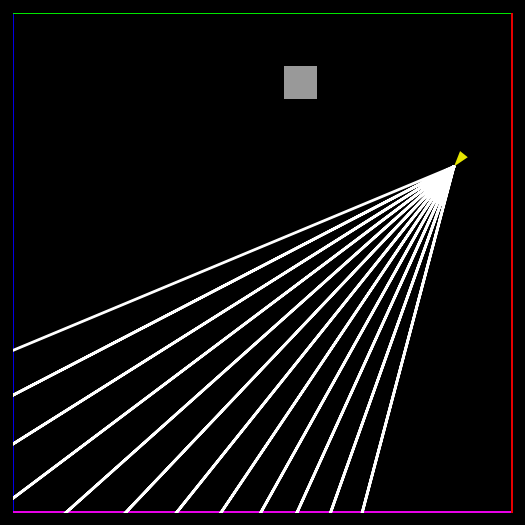

In [123]:
fig, ax = pplt.subplots()

print(env.step(1))

env.render(ax=ax)
ax.format(xlim=[0, 300], ylim=[0, 300])

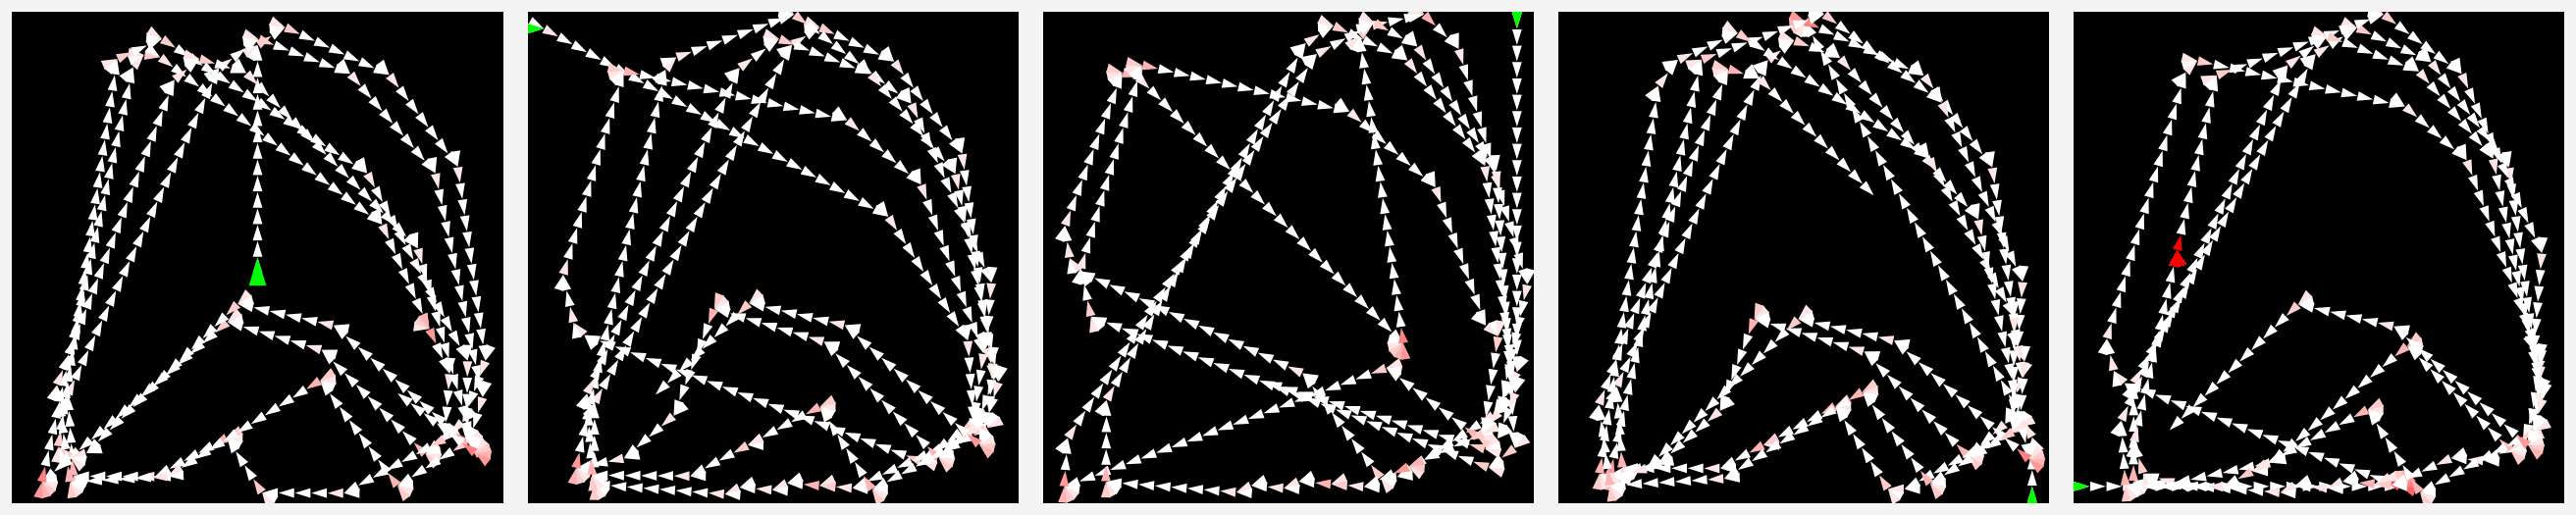

In [50]:
effs, trajs = test_search_efficiency(model, obs_rms, env_kwargs=env_kwargs)

fig, ax = pplt.subplots(ncols=5)

for i in range(5):
    draw_trajectory(trajs[i][0], trajs[i][1], ax=ax[i])